In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from time import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import torchvision.models as models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
batch_size = 32
learn_rate = 0.001
count_epoch = 20

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss().to(device)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
dir = '/content/drive/MyDrive/Garbage classification'

classes = os.listdir(dir)
dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Garbage classification', transform=transform)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.7, 0.15, 0.15])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

print(f'Размер тренировочной выборки: {len(train_loader.dataset.indices)}')
print(f'Размер валидационной выборки: {len(val_loader.dataset.indices)}')
print(f'Размер тестовой выборки: {len(test_loader.dataset.indices)}')
print('GPU or CPU:', device)

Размер тренировочной выборки: 1769
Размер валидационной выборки: 379
Размер тестовой выборки: 379
GPU or CPU: cuda


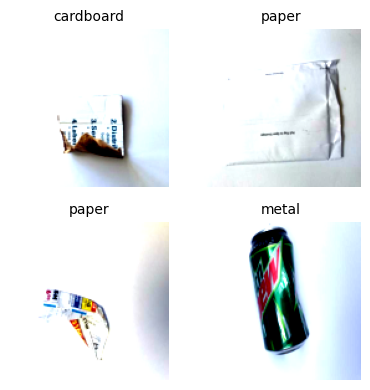

In [ ]:
def plot_images(images, labels, classes, rows=2, cols=2):
    np_images = np.clip((images / 2.0 + 0.5).numpy(), 0, 1)
    num_images = min(len(images), rows * cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    for i in range(num_images):
        axes[i].imshow(np.transpose(np_images[i], (1, 2, 0)))
        axes[i].axis('off')
        axes[i].set_title(classes[labels[i]], fontsize=10)

    for ax in axes[num_images:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
plot_images(images, labels, dataset.classes)

In [ ]:
def model_device(model):
    return next(model.parameters()).device

@torch.no_grad()
def F1_score(model, dataloader: DataLoader):
    device = model_device(model)
    f1_all = []
    model.eval()

    for images, labels in dataloader:

        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        f1 = f1_score(labels.cpu(), preds.cpu(), average="macro")
        f1_all.append(f1)

    return sum(f1_all) / len(f1_all)

In [ ]:

def ResNet50_default(num_classes: int):
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model

def ResNet50_modified(num_classes: int):

    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

    for param in model.parameters():
        param.requires_grad = False

    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(model.fc.in_features, 512),
        nn.ReLU(),
        nn.Linear(512, num_classes),
    )

    return model

def DenseNet121_default(num_classes: int):

    model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)

    return model


def DenseNet121_modified(num_classes: int):

    model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

    for i, param in enumerate(model.parameters()):

       if i < 6 + 12:

           param.requires_grad = False
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)

    return model


def GoogleNet_default(num_classes: int):

    model = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model

def GoogleNet_modified(num_classes: int):

    model = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)

    for param in model.parameters():
        param.requires_grad = False

    for param in model.inception5b.parameters():
        param.requires_grad = True

    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 1024),
        nn.ReLU(),
        nn.BatchNorm1d(1024),
        nn.Dropout(0.5),
        nn.Linear(1024, num_classes)
    )

    return model

def MobileNet_v2_default(num_classes: int):

    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    return model


def mobilenet_v2_modified(num_classes: int):

    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

    for param in model.parameters():
        param.requires_grad = False

    conv_block = nn.Sequential(
        nn.Conv2d(in_channels=1280, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
    )

    old_feature = model.features[-1]
    model.features[-1] = nn.Sequential(old_feature, conv_block)
    model.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(512, num_classes),
    )

    return model

In [ ]:
def train_model(model, name, train_loader, val_loader, num_epochs, learning_rate):

    device = model_device(model)
    optimizer = torch.optim.Adam(filter(lambda param: param.requires_grad, model.parameters()), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    best_f1 = 0.0
    val_f1_stat = []

    for epoch in range(num_epochs):

        model.train()
        start_time = time()

        for images, labels in train_loader:

            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        train_time = time() - start_time
        start_time = time()

        val_f1 = F1_score(model, val_loader)
        val_time = time() - start_time

        if val_f1 > best_f1:

            torch.save(model.state_dict(), f"best_{name}.pth")
            best_f1 = val_f1

        val_f1_stat.append(val_f1)
        print(f"Epoch {epoch}: Train t {train_time:.4f} s, Val t {val_time:.4f} s, Val F1 {val_f1:.5f}", flush=True)
        print("-----------------------------------------------------------------------------------")

    return val_f1_stat

In [ ]:
def run_model(model_factory):

    global test_f1_stat

    model = model_factory(len(classes)).to(device)
    name = model_factory.__name__

    val_f1_stat = train_model(model, name, train_loader, val_loader, count_epoch, learn_rate)
    model.load_state_dict(torch.load(f"best_{name}.pth", weights_only=True))
    test_f1 = F1_score(model, test_loader)

    print("Test F1:", test_f1)

    plt.plot(range(count_epoch), val_f1_stat, marker="o", color = "black")
    plt.title(f"{name} val")
    plt.xlabel("Epoch")
    plt.xticks([i for i in range(count_epoch)])
    plt.ylabel("F1 Score")
    plt.grid()

    plt.show()

    test_f1_stat[name] = test_f1

test_f1_stat = {}

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 171MB/s]


Epoch 0: Train t 442.6231 s, Val t 90.7336 s, Val F1 0.66047
-----------------------------------------------------------------------------------
Epoch 1: Train t 11.4255 s, Val t 2.3370 s, Val F1 0.78153
-----------------------------------------------------------------------------------
Epoch 2: Train t 11.4479 s, Val t 2.4562 s, Val F1 0.76037
-----------------------------------------------------------------------------------
Epoch 3: Train t 11.0927 s, Val t 2.3970 s, Val F1 0.81388
-----------------------------------------------------------------------------------
Epoch 4: Train t 11.3200 s, Val t 2.6603 s, Val F1 0.76790
-----------------------------------------------------------------------------------
Epoch 5: Train t 10.9339 s, Val t 2.5654 s, Val F1 0.80279
-----------------------------------------------------------------------------------
Epoch 6: Train t 10.8719 s, Val t 2.6155 s, Val F1 0.75181
---------------------------------------------------------------------------------

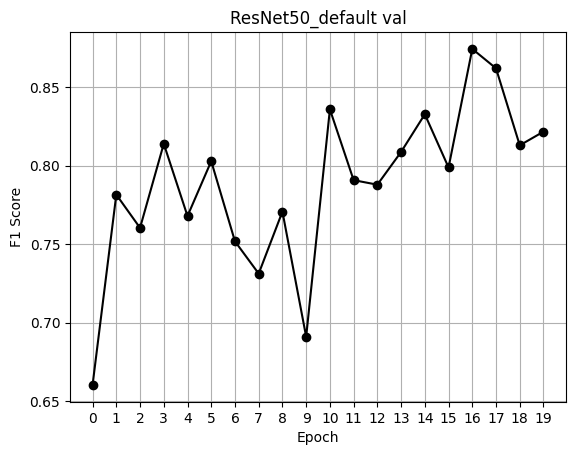

In [ ]:
run_model(ResNet50_default)

Epoch 0: Train t 10.4310 s, Val t 2.5553 s, Val F1 0.76688
-----------------------------------------------------------------------------------
Epoch 1: Train t 10.5066 s, Val t 2.4594 s, Val F1 0.74723
-----------------------------------------------------------------------------------
Epoch 2: Train t 10.3430 s, Val t 2.4848 s, Val F1 0.77585
-----------------------------------------------------------------------------------
Epoch 3: Train t 10.5244 s, Val t 2.4302 s, Val F1 0.77953
-----------------------------------------------------------------------------------
Epoch 4: Train t 10.7006 s, Val t 2.5138 s, Val F1 0.81324
-----------------------------------------------------------------------------------
Epoch 5: Train t 10.7338 s, Val t 2.4816 s, Val F1 0.78227
-----------------------------------------------------------------------------------
Epoch 6: Train t 10.4538 s, Val t 2.4486 s, Val F1 0.78708
-----------------------------------------------------------------------------------

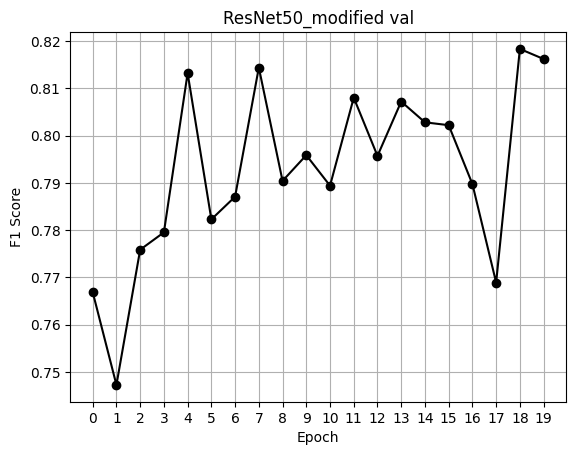

In [ ]:
run_model(ResNet50_modified)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 155MB/s]


Epoch 0: Train t 13.5087 s, Val t 2.4062 s, Val F1 0.61397
-----------------------------------------------------------------------------------
Epoch 1: Train t 13.1996 s, Val t 2.2559 s, Val F1 0.71279
-----------------------------------------------------------------------------------
Epoch 2: Train t 13.3553 s, Val t 2.3212 s, Val F1 0.67878
-----------------------------------------------------------------------------------
Epoch 3: Train t 13.3605 s, Val t 2.7639 s, Val F1 0.76979
-----------------------------------------------------------------------------------
Epoch 4: Train t 13.3030 s, Val t 2.6062 s, Val F1 0.71273
-----------------------------------------------------------------------------------
Epoch 5: Train t 13.2506 s, Val t 2.3529 s, Val F1 0.80088
-----------------------------------------------------------------------------------
Epoch 6: Train t 13.3870 s, Val t 2.4627 s, Val F1 0.75765
-----------------------------------------------------------------------------------

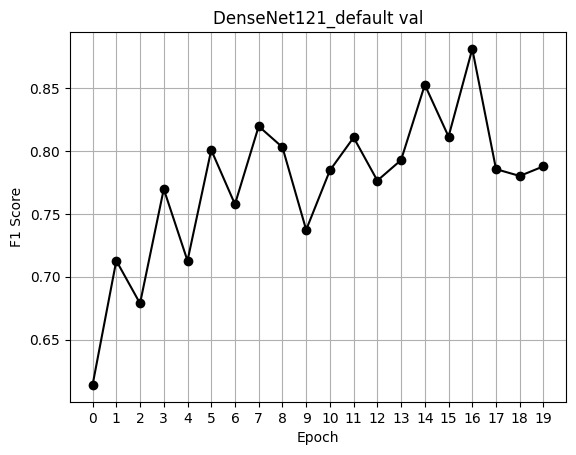

In [ ]:
run_model(DenseNet121_default)

Epoch 0: Train t 13.3007 s, Val t 2.3397 s, Val F1 0.58737
-----------------------------------------------------------------------------------
Epoch 1: Train t 13.2578 s, Val t 2.3759 s, Val F1 0.63372
-----------------------------------------------------------------------------------
Epoch 2: Train t 13.2232 s, Val t 2.3185 s, Val F1 0.77723
-----------------------------------------------------------------------------------
Epoch 3: Train t 13.1967 s, Val t 2.3430 s, Val F1 0.67175
-----------------------------------------------------------------------------------
Epoch 4: Train t 13.2940 s, Val t 2.7100 s, Val F1 0.85071
-----------------------------------------------------------------------------------
Epoch 5: Train t 13.2017 s, Val t 2.7260 s, Val F1 0.79527
-----------------------------------------------------------------------------------
Epoch 6: Train t 13.4352 s, Val t 2.4238 s, Val F1 0.86234
-----------------------------------------------------------------------------------

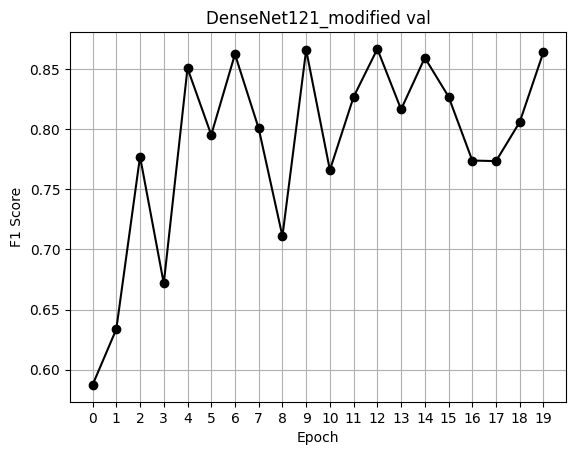

In [ ]:
run_model(DenseNet121_modified)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 113MB/s]


Epoch 0: Train t 11.6919 s, Val t 2.2063 s, Val F1 0.58547
-----------------------------------------------------------------------------------
Epoch 1: Train t 11.1910 s, Val t 2.2381 s, Val F1 0.70683
-----------------------------------------------------------------------------------
Epoch 2: Train t 11.0343 s, Val t 2.2135 s, Val F1 0.73322
-----------------------------------------------------------------------------------
Epoch 3: Train t 11.1693 s, Val t 2.2173 s, Val F1 0.74759
-----------------------------------------------------------------------------------
Epoch 4: Train t 11.1278 s, Val t 2.2382 s, Val F1 0.69845
-----------------------------------------------------------------------------------
Epoch 5: Train t 11.1538 s, Val t 2.3003 s, Val F1 0.73461
-----------------------------------------------------------------------------------
Epoch 6: Train t 11.2416 s, Val t 2.2366 s, Val F1 0.78583
-----------------------------------------------------------------------------------

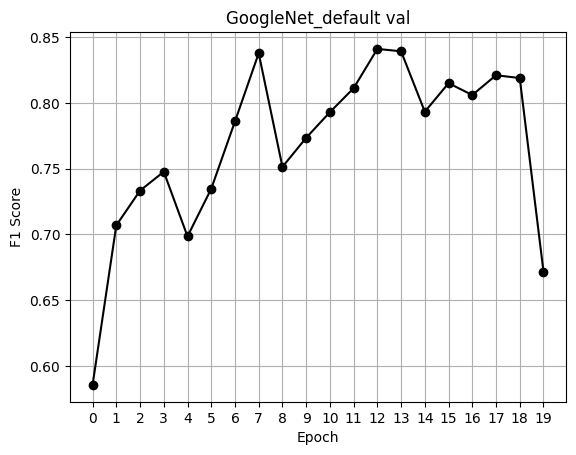

In [ ]:
run_model(GoogleNet_default)

Epoch 0: Train t 10.8051 s, Val t 2.7070 s, Val F1 0.71183
-----------------------------------------------------------------------------------
Epoch 1: Train t 9.9133 s, Val t 2.6447 s, Val F1 0.74638
-----------------------------------------------------------------------------------
Epoch 2: Train t 9.9248 s, Val t 2.5470 s, Val F1 0.74735
-----------------------------------------------------------------------------------
Epoch 3: Train t 10.0691 s, Val t 2.3876 s, Val F1 0.78760
-----------------------------------------------------------------------------------
Epoch 4: Train t 10.2132 s, Val t 2.2839 s, Val F1 0.74869
-----------------------------------------------------------------------------------
Epoch 5: Train t 10.4605 s, Val t 2.1948 s, Val F1 0.77863
-----------------------------------------------------------------------------------
Epoch 6: Train t 10.4641 s, Val t 2.1500 s, Val F1 0.75326
-----------------------------------------------------------------------------------
E

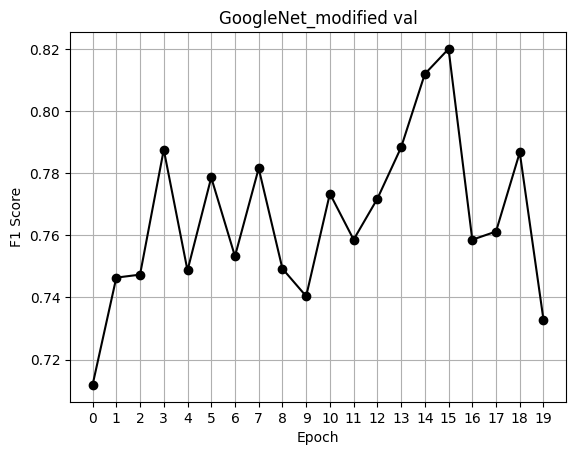

In [ ]:
run_model(GoogleNet_modified)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 46.9MB/s]


Epoch 0: Train t 11.0822 s, Val t 2.1347 s, Val F1 0.75002
-----------------------------------------------------------------------------------
Epoch 1: Train t 11.0556 s, Val t 2.1098 s, Val F1 0.78955
-----------------------------------------------------------------------------------
Epoch 2: Train t 10.9967 s, Val t 2.1662 s, Val F1 0.86133
-----------------------------------------------------------------------------------
Epoch 3: Train t 11.9042 s, Val t 2.1723 s, Val F1 0.86945
-----------------------------------------------------------------------------------
Epoch 4: Train t 11.1498 s, Val t 2.1788 s, Val F1 0.80472
-----------------------------------------------------------------------------------
Epoch 5: Train t 10.9734 s, Val t 2.1593 s, Val F1 0.82640
-----------------------------------------------------------------------------------
Epoch 6: Train t 11.0649 s, Val t 2.0978 s, Val F1 0.88639
-----------------------------------------------------------------------------------

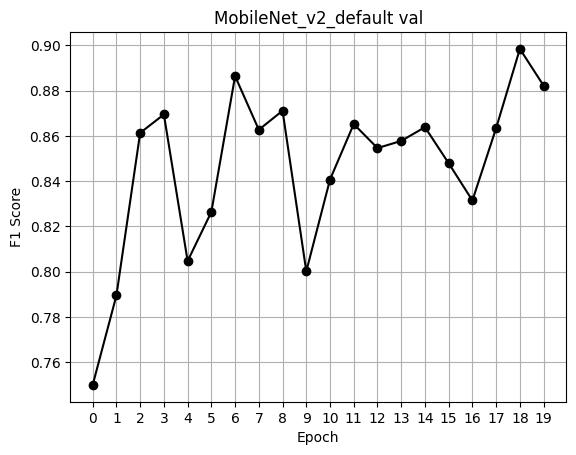

In [ ]:
run_model(MobileNet_v2_default)

Epoch 0: Train t 10.3740 s, Val t 2.1378 s, Val F1 0.73709
-----------------------------------------------------------------------------------
Epoch 1: Train t 10.1962 s, Val t 2.2487 s, Val F1 0.74059
-----------------------------------------------------------------------------------
Epoch 2: Train t 9.8518 s, Val t 2.5081 s, Val F1 0.78706
-----------------------------------------------------------------------------------
Epoch 3: Train t 9.6058 s, Val t 2.6743 s, Val F1 0.77023
-----------------------------------------------------------------------------------
Epoch 4: Train t 9.6446 s, Val t 2.4320 s, Val F1 0.78200
-----------------------------------------------------------------------------------
Epoch 5: Train t 10.6508 s, Val t 2.3694 s, Val F1 0.79533
-----------------------------------------------------------------------------------
Epoch 6: Train t 10.0279 s, Val t 2.1390 s, Val F1 0.78920
-----------------------------------------------------------------------------------
Ep

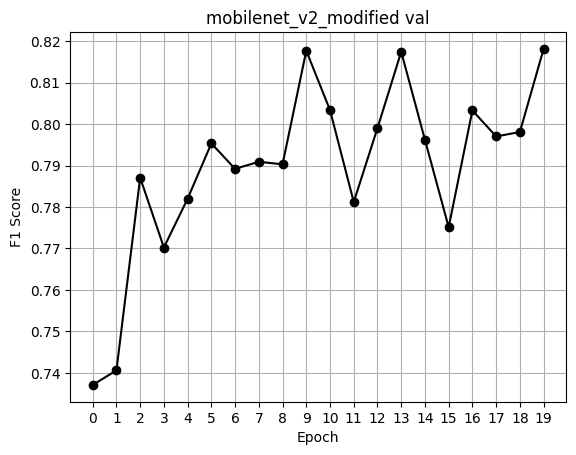

In [ ]:
run_model(mobilenet_v2_modified)

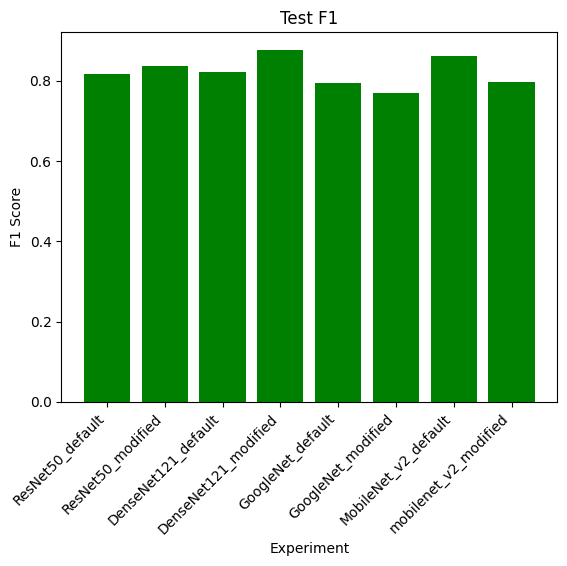

In [ ]:
model_names = [*test_f1_stat.keys()]
f1_scores = [*test_f1_stat.values()]
plt.bar(model_names, f1_scores, color="green")
plt.xlabel("Experiment")
plt.ylabel("F1 Score")
plt.title("Test F1")
plt.xticks(rotation=45, ha="right")
plt.show()